In [124]:
### load packages

# general packages
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import time
import os
import numpy as np
from random import randint
%matplotlib inline

# weights and biases for metric training
import wandb
from torch import optim
import time
import math

# data science
from sklearn.model_selection import train_test_split

# torch stuff
import torch
from torch.utils.data import DataLoader, Dataset, sampler
import torchvision.models as models
from torchvision.transforms import Resize, Scale, Normalize, RandomHorizontalFlip, ToTensor, Compose, ToPILImage
import torch.nn as nn

# device is cuda if gpu is availabe
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_df = pd.read_csv("./input/train.csv")

print(len(train_df))


7095


### Visualization of Image Segmentation on Training Data
code taken from kaggle notebook

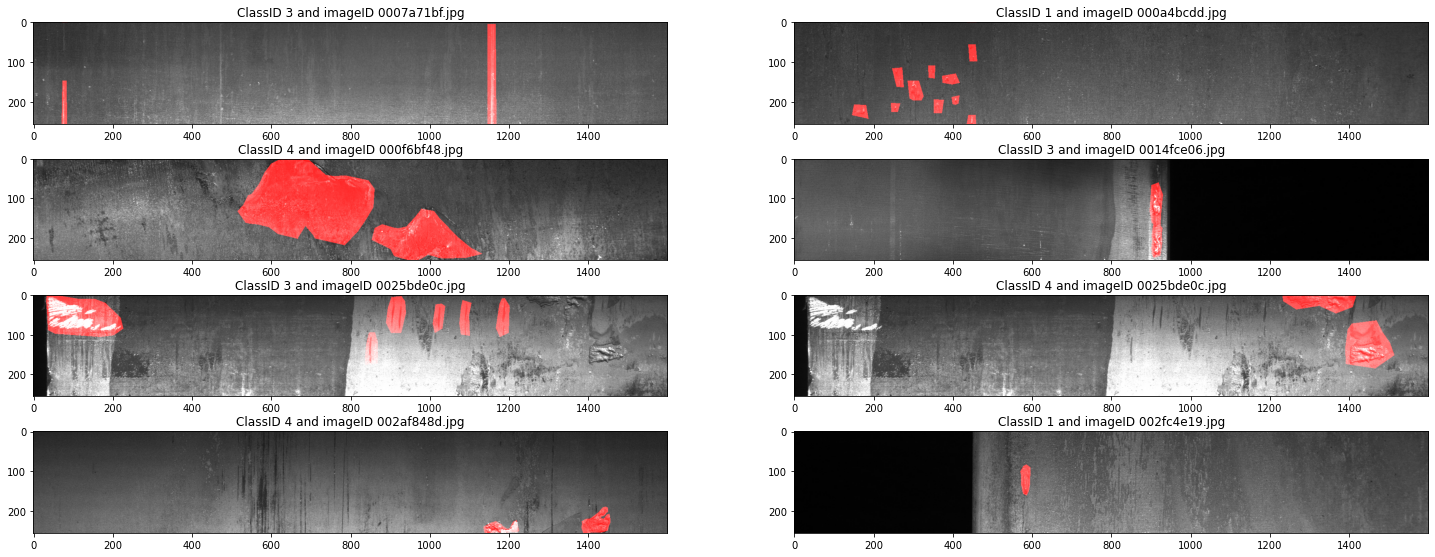

In [125]:
def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def rle2mask(rle, imgshape):

    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])

    # print('array', array)
    # print('array.shape', array.shape)

    starts = array[0::2]
    lengths = array[1::2]

    # print('starts',starts)
    # print('lengths',lengths)

    current_position = 0

    for index, start in enumerate(starts):

        mask[int(start):int(start+lengths[index])] = 1

        # current position is not used
        current_position += lengths[index]      

    # pixels in df are numbered from top to bottom, thats why we do upside down flip
    # but I dunno why we need to rotate it, p
    return np.flipud( np.rot90( mask.reshape(height,width), k=1 ) )


fig=plt.figure(figsize=(25,125))
columns = 2
rows = 50

for i in range(1, 20+1):
    fig.add_subplot(rows, columns, i)

    fn = train_df['ImageId'].iloc[i]
    img = cv2.imread('input/train_images/' + fn)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = rle2mask( train_df['EncodedPixels'].iloc[i], img.shape)

    # ,0 relates to the channel dimension
    img[mask==1, 0] = 255

    class_id = str(train_df['ClassId'].iloc[i])
    plt.gca().set_title(f'ClassID {class_id} and imageID {fn}')
    plt.imshow(img)

    if i == 8:
        break

plt.show()

In [220]:
def get_image(scale_factor):
    BATCH_TEST = 1
    num_workers = 0

    test_data = provider_v2(data_folder='input/',
                df_path='input/train.csv',
                phase='test',
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                rescale_factor = scale_factor,
                batch_size = BATCH_TEST,
                num_workers = num_workers,
                shuffle=False)

    for idx, (el,label) in enumerate(test_data):

        el = inverse_normalize(tensor=el, 
                                mean=(0.485, 0.456, 0.406), 
                                std=(0.229, 0.224, 0.225))

        img = el[0].permute(1, 2, 0).numpy()

        fig=plt.figure(figsize=(20,100))

        plt.gca().set_title(f'ClassID {label[0]}')
        plt.imshow(img)
        plt.show()

        if idx == 2:
            break

Class distribution of whole set w/o 


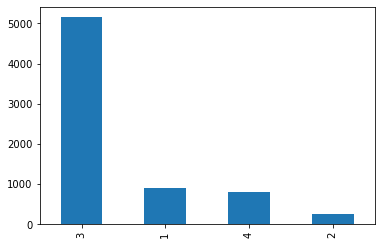

In [221]:
df = train_df
print(f'Class distribution of whole set w/o ')
df['ClassId'].value_counts().plot.bar()
plt.show()

In [235]:
def get_full_df(df, train_image_folder):
    'Extend class data frame with images of non defects. Encode them with class id 0'

    all_file_names = os.listdir(train_image_folder)

    labeled_file_names = df['ImageId'].to_list()

    complement_file_names = list(set(all_file_names) - set(labeled_file_names))

    missing_files_df = pd.DataFrame(data={'ImageId': complement_file_names, 'ClassId': [0]*len(complement_file_names) })

    full_df =  pd.concat([df,missing_files_df])
    
    return full_df

df_path = 'input/train.csv'
data_folder='input/'
df = pd.read_csv(df_path)

train_image_folder = os.path.join(data_folder, "train_images")
df = get_full_df(df, train_image_folder)

weights_dict = (1 / df['ClassId'].value_counts()).sort_index().to_dict()
weights_tensor = torch.tensor((1 / df['ClassId'].value_counts()).sort_index().values).float().to(device)

print(f'Number of classes {len(weights_tensor)}')
print()
print('weight dict', weights_dict)
print('weight tens', weights_tensor)

Number of classes 5

weight dict {0: 0.00016943409013893597, 1: 0.0011148272017837235, 2: 0.004048582995951417, 3: 0.0001941747572815534, 4: 0.0012484394506866417}
weight tens tensor([0.0002, 0.0011, 0.0040, 0.0002, 0.0012])


<AxesSubplot:>

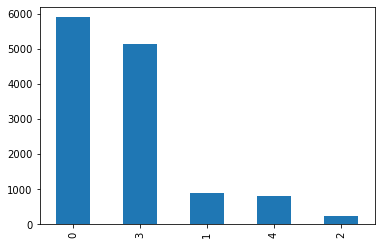

In [236]:
df['ClassId'].value_counts().plot.bar()

In [257]:
def get_transforms(phase, mean, std, new_img_size):
    list_transforms = []
    
    list_transforms.extend([ToPILImage(),])
    
    if phase == "train":
        list_transforms.extend(
            [       
                RandomHorizontalFlip(p=0.5), # only horizontal flip as of now
            ]
        )
        
    list_transforms.extend(
        [
            Resize(new_img_size),
            ToTensor(),
            Normalize(mean=mean, std=std),       
        ]
    )
    
    list_trfms = Compose(list_transforms)
    return list_trfms

class SteelDataset_v2(Dataset):

    def __init__(self, df, data_folder, mean, std, phase, rescale_factor = None):
        
        self.df = df
        self.root = data_folder        

        # get orig image size and calcualte new img size
        image_id = self.df.iloc[0]['ImageId']
        image_path = os.path.join(self.root, "train_images",  image_id)
        img = cv2.imread(image_path)        
        orig_img_size = img.shape[0:2]

        if rescale_factor is not None:
            self.new_img_size = [int(el*rescale_factor) for el in orig_img_size]
        else:
            self.new_img_size = orig_img_size

        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std, self.new_img_size)
        self.fnames = self.df.index.tolist()
        self.rescale_factor = rescale_factor


    def __getitem__(self, idx):

        image_id = self.df.iloc[idx]['ImageId']
        class_id = self.df.iloc[idx]['ClassId']

        image_path = os.path.join(self.root, "train_images",  image_id)

        start_time = time.time()
        
        img = cv2.imread(image_path)   
        img = self.transforms(img)
        
        return img, class_id

    def __len__(self):
        return len(self.fnames)


def provider_v2(
    data_folder,
    df_path,
    phase,
    mean=None,
    std=None,
    rescale_factor = None,
    batch_size=8,
    num_workers=0,
    shuffle=True
    ):
    
    '''Returns dataloader for the model training'''
    df = pd.read_csv(df_path)
    
    train_image_folder = os.path.join(data_folder, "train_images")
    
    # extend df with ids of images that are not in the original df
    df = get_full_df(df, train_image_folder)

    df['ClassId'] = df['ClassId'].astype(int) 
    
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=69)
    
    if phase == "train":
        df = train_df 
    elif phase == "test":
        df = val_df
        
    image_dataset = SteelDataset_v2(df, data_folder, mean, std, phase, rescale_factor)
    
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=shuffle,   
    )

    return dataloader



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


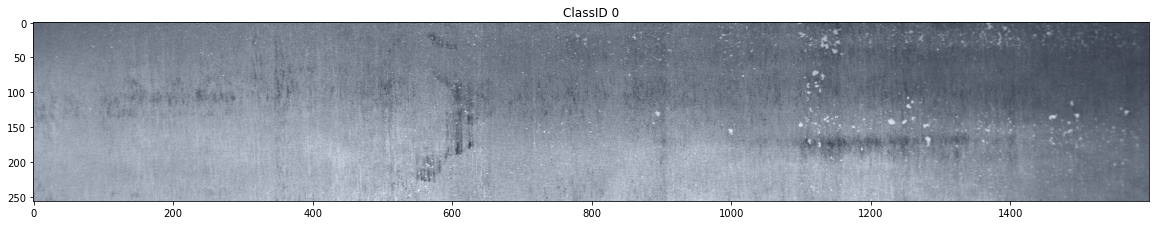

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


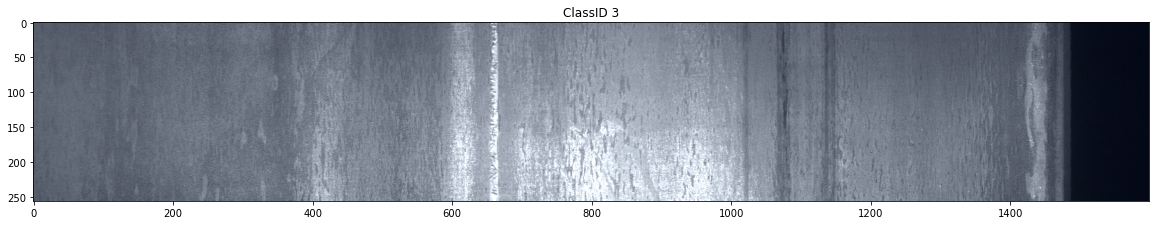

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


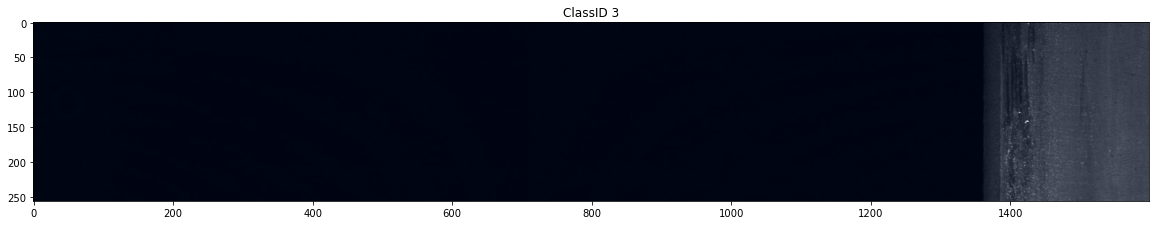

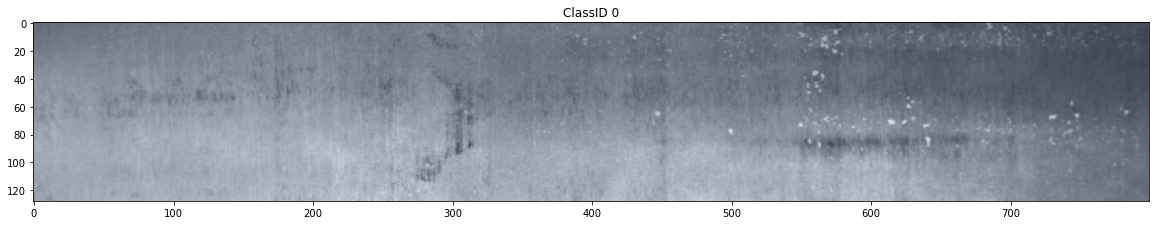

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


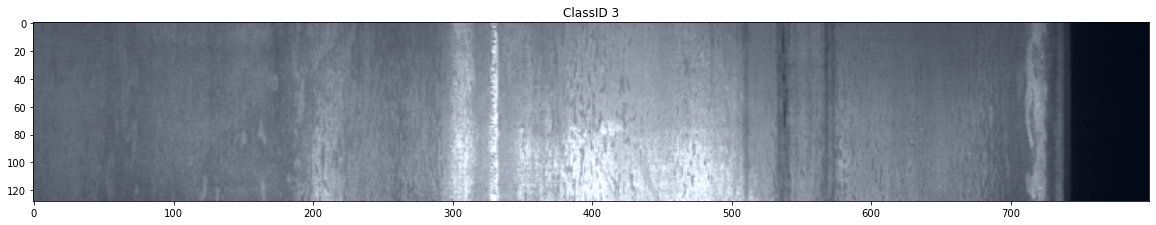

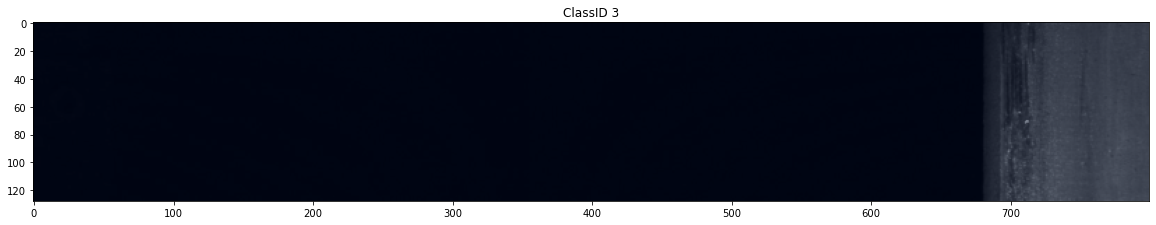

In [258]:
## Check downscaled image quality manually
get_image(scale_factor=1)
print()
get_image(scale_factor=0.5)

In [259]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score

def accuracy(target, pred):
    """Not a good metric for imbalanced dataset. However, it's a start."""
    return (target == pred.argmax(dim=1)).float().mean()

def conf_matrix(target, pred):
    """
    Args: torch.tensors
    Returns: np matrix
    """
    # apparently have to first detach and then convert to np manually for conf matrix
    return confusion_matrix(target, pred.argmax(axis=1))

def bal_acc(target, pred):
    """
    Average of the recalls per class
    """
    return balanced_accuracy_score(target.cpu().numpy(), pred.cpu().numpy())



In [260]:
resnet18 = models.resnet18(pretrained=True)
model = resnet18

for param in model.parameters():
    print(param.requires_grad)
    param.requires_grad = False
    print(param.requires_grad)
    break

True
False


In [261]:
# load pre trained resnet18
resnet18 = models.resnet18(pretrained=True)
model = resnet18

model.to(device)

# adjust output layer to number of classes
model.fc = nn.Linear(512, len(weights_tensor)).to(device)

In [262]:
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(512, len(weights_tensor)).to(device)

PATH = 'model/model.h5'
model.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))
model.to(device)

if device.type == 'cuda':
    !nvidia-smi

In [263]:
# create train and test data with 1/5 split and 0.25 downscaling of images
BATCH_SIZE = 64
BATCH_TEST = 128
num_workers = 0
SCALE_FACTOR = 0.75

train_data = provider_v2(data_folder='input/',
                df_path='input/train.csv',
                phase='train',
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                rescale_factor = SCALE_FACTOR,
                batch_size = BATCH_SIZE,
                num_workers = num_workers)

test_data = provider_v2(data_folder='input/',
                df_path='input/train.csv',
                phase='test',
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                rescale_factor = SCALE_FACTOR,
                batch_size = BATCH_TEST,
                num_workers = num_workers)

# data points in train and test set
print("Number of samples in train and test set")
print(len(train_data)*BATCH_SIZE)
print(len(test_data)*BATCH_TEST)

Number of samples in train and test set
10432
2688


In [271]:
def test_eval(model, 
              SAVE_FLAG, 
              log_wandb=True,
              model_name='model', 
              conf_mat_name='conf_mat_test'):

    loss_test = []
    total_pred = torch.tensor([]).to(device)
    total_pred_probs = torch.tensor([]).to(device)    
    total_target = torch.tensor([]).to(device)
    
    print('\n### EVAL TEST SET ###')

    if SAVE_FLAG:
        torch.save(model.state_dict(), f'defect_identification/model/{model_name}.h5')
        
    model.eval()

    for idx_test, (el,label) in enumerate(test_data):

        el = el.to(device)
        label = label.to(device)

        start = time.time()
        
        with torch.no_grad():
            pred = model(el)

        loss_test.append(ce_loss(pred, label))

        print(f'Iter {idx_test} / {len(test_data)} with loss {(sum(loss_test)/len(loss_test)):.2f} in {(time.time() - start):.2f} s') 
        
        total_pred = torch.cat([total_pred, pred.argmax(dim=1)])
        total_pred_probs = torch.cat([total_pred_probs, pred])        
        total_target = torch.cat([total_target, label])   

        # if idx_test == 3:
        #     break
    
    bal_acc_test = bal_acc(total_target, total_pred)
    avg_loss_test = sum(loss_test)/len(loss_test)
    
    print(f'\nTest loss: {avg_loss_test}')
    print(f'Balanced acc: {bal_acc_test}')
    
    class_names = ['0', '1', '2', '3', '4']    

#     if log_wandb:
#         wandb.log({"loss_test": avg_loss_test, 
#                     "bal_acc_test": bal_acc_test, 
#                     conf_mat_name: wandb.plot.confusion_matrix(probs=total_pred_probs.detach().cpu().numpy(), y_true=total_target.detach().cpu().numpy(), class_names = class_names)})       

    confm = conf_matrix(target=total_target.detach().cpu().numpy(),
                        pred=total_pred_probs.detach().cpu().numpy())  
                   
    confm_normed = np.round(confm/(confm.sum(axis=1)[:,np.newaxis])*100, 0)
    print('\nNormalized Confusion Matrix [%]')
    print(confm_normed)
    print('\nAbsolute Confusion Matrix [%]')
    print(confm)

    print('### END EVAL TEST ###\n')

In [272]:
optimizer = optim.Adam(model.parameters())

ce_loss = nn.CrossEntropyLoss(weight = weights_tensor)

In [267]:
EPOCHS = 20
SAVE_FLAG = False
run_id = randint(0, 100)

        
for epoch in range(EPOCHS):
    
    print(f'### EPOCH {epoch} ###\n')
    
    start_time = time.time()

    for idx, (x, label) in enumerate(train_data):

        start = time.time()
        x = x.to(device)

        label = label.to(device)

        # train model
        optimizer.zero_grad()
        model.train()
        start = time.time()    
        pred = model(x)

        # print('pred.device',pred.device)
        # print('label.device',label.device)

        loss = ce_loss(pred, label)   

        loss.backward()

        optimizer.step()    

        # print stuff
        print(f'Iter {idx} / {len(train_data)} loss {loss.item():.2f} in {(time.time() - start):.2f} s')
        print(f'Plain accuracy: {accuracy(label, pred):.2f}')
        bal_acc_train = bal_acc(label, pred.argmax(dim=1))
        print(f'Aveg. accuracy: {bal_acc_train:.2f}')
        
        # log stuff for weights and biases
        class_names = ['0', '1', '2', ac'3', '4'] 
#         wandb.log({"loss_train": loss, 
#                    "bal_acc_train": bal_acc_train})
        
        pred_np = pred.detach().cpu().numpy().argmax(axis=1)
        y_true_np = label.cpu().numpy()

        print(f'Iter in {time.time() - start} seconds') 
        print()

    # eval test set
    test_eval(model, SAVE_FLAG) 
    print(f'Total Time per Epoch {time.time() - start_time}')  
    print(f'### END EPOCH ###\n')



### EPOCH 0 ###

Iter 0 / 163 loss 0.11 in 32.82 s
Plain accuracy: 0.95
Aveg. accuracy: 0.98
Iter in 32.832533836364746 seconds



KeyboardInterrupt: 

## Testing

In [273]:
SCALE_FACTOR = 0.75

train_data = provider_v2(data_folder='input/',
                df_path='input/train.csv',
                phase='train',
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                rescale_factor = SCALE_FACTOR,
                batch_size = BATCH_SIZE,
                num_workers = num_workers)

test_data = provider_v2(data_folder='input/',
                df_path='input/train.csv',
                phase='test',
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                rescale_factor = SCALE_FACTOR,
                batch_size = BATCH_TEST,
                num_workers = num_workers)

In [274]:
SAVE_FLAG = False
run_id = randint(0,100)

print(f'Run ID {run_id}')

# run = wandb.init(project='defect_identification', name=f'test_run_{run_id}')

start_time = time.time()

test_eval(model, 
          SAVE_FLAG,
          log_wandb=True)

print()
print(f'total time {time.time() - start_time}')
print()

# run.finish()

Run ID 0

### EVAL TEST SET ###
Iter 0 / 21 with loss 0.95 in 12.54 s
Iter 1 / 21 with loss 1.14 in 12.11 s
Iter 2 / 21 with loss 0.94 in 12.13 s
Iter 3 / 21 with loss 0.79 in 12.20 s
Iter 4 / 21 with loss 0.75 in 12.22 s
Iter 5 / 21 with loss 0.73 in 12.24 s
Iter 6 / 21 with loss 0.75 in 13.59 s
Iter 7 / 21 with loss 0.75 in 11.90 s
Iter 8 / 21 with loss 0.70 in 11.89 s
Iter 9 / 21 with loss 0.73 in 11.90 s
Iter 10 / 21 with loss 0.72 in 12.29 s
Iter 11 / 21 with loss 0.72 in 12.42 s
Iter 12 / 21 with loss 0.71 in 11.81 s
Iter 13 / 21 with loss 0.72 in 11.75 s
Iter 14 / 21 with loss 0.70 in 13.24 s
Iter 15 / 21 with loss 0.78 in 11.96 s
Iter 16 / 21 with loss 0.80 in 13.50 s
Iter 17 / 21 with loss 0.81 in 12.07 s
Iter 18 / 21 with loss 0.81 in 12.55 s
Iter 19 / 21 with loss 0.80 in 12.58 s
Iter 20 / 21 with loss 0.80 in 4.35 s

Test loss: 0.7994639873504639
Balanced acc: 0.7741235840825329

Normalized Confusion Matrix [%]
[[98.  0.  0.  1.  1.]
 [21. 64.  2. 12.  1.]
 [20. 14. 57.  8.